<a href="https://colab.research.google.com/github/LazaroR-u/GSoC_QMLHEP_2024/blob/main/tasks/task_VI_Contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VI. Contrastive learning

In this task you should implement a simple representation learning scheme based on a contrastive loss:

- Load the MNIST dataset
- Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations
- Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. In the end the measurement should give the fidelity of the quantum states.
- Train the circuit parameters with a contrastive loss: For two MNIST images in the same class the fidelity should be maximized, while for images of different classes the fidelity should be minimized.

In [1]:
%%capture
pip install pennylane

In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer
import tensorflow as tf

In [3]:
dev = qml.device('lightning.qubit', wires=9)

## Load MNIST data

In [8]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Scale the inputs in range of (-1, +1) for better training
x_train_flatten, x_test_flatten = x_train / 255.0 , x_test / 255.0

Separate the dataset into classes


In [10]:
x_train_0 = x_train_flatten[y_train == 0]
x_train_1 = x_train_flatten[y_train == 1]
x_train_2 = x_train_flatten[y_train == 2]
x_train_3 = x_train_flatten[y_train == 3]
x_train_4 = x_train_flatten[y_train == 4]
x_train_5 = x_train_flatten[y_train == 5]
x_train_6 = x_train_flatten[y_train == 6]
x_train_7 = x_train_flatten[y_train == 7]
x_train_8 = x_train_flatten[y_train == 8]
x_train_9 = x_train_flatten[y_train == 9]

x_train_list = [x_train_0, x_train_1, x_train_2, x_train_3, x_train_4, x_train_5, x_train_6, x_train_7, x_train_8, x_train_9]

print(x_train_0.shape)
print(x_train_1.shape)
print(x_train_2.shape)
print(x_train_3.shape)
print(x_train_4.shape)
print(x_train_5.shape)
print(x_train_6.shape)
print(x_train_7.shape)
print(x_train_8.shape)
print(x_train_9.shape)

x_test_0 = x_test_flatten[y_test == 0]
x_test_1 = x_test_flatten[y_test == 1]
x_test_2 = x_test_flatten[y_test == 2]
x_test_3 = x_test_flatten[y_test == 3]
x_test_4 = x_test_flatten[y_test == 4]
x_test_5 = x_test_flatten[y_test == 5]
x_test_6 = x_test_flatten[y_test == 6]
x_test_7 = x_test_flatten[y_test == 7]
x_test_8 = x_test_flatten[y_test == 8]
x_test_9 = x_test_flatten[y_test == 9]

x_test_list = [x_test_0, x_test_1, x_test_2, x_test_3, x_test_4, x_test_5, x_test_6, x_test_7, x_test_8, x_test_9]

(5923, 28, 28)
(6742, 28, 28)
(5958, 28, 28)
(6131, 28, 28)
(5842, 28, 28)
(5421, 28, 28)
(5918, 28, 28)
(6265, 28, 28)
(5851, 28, 28)
(5949, 28, 28)


We choose 2 classes: 0 and 1 to classify


In [11]:
class_set = [0, 1]

training_sample_per_class = 200  # number of training samples per class
X_train = np.concatenate((x_train_list[class_set[0]][:training_sample_per_class, :], x_train_list[class_set[1]][:training_sample_per_class, :]), axis=0)
Y_train = np.zeros((X_train.shape[0],), dtype=int)
Y_train[training_sample_per_class:] += 1

print("Train Set Shape:", X_train.shape, Y_train.shape)

testing_sample_per_class = 100  # number of testing samples per class
X_test = np.concatenate((x_test_list[class_set[0]][:testing_sample_per_class, :], x_test_list[class_set[1]][:testing_sample_per_class, :]), axis=0)
Y_test = np.zeros((X_test.shape[0],), dtype=int)
Y_test[testing_sample_per_class:] += 1

print("Test Set Shape:", X_test.shape, Y_test.shape)

Train Set Shape: (400, 28, 28) (400,)
Test Set Shape: (200, 28, 28) (200,)


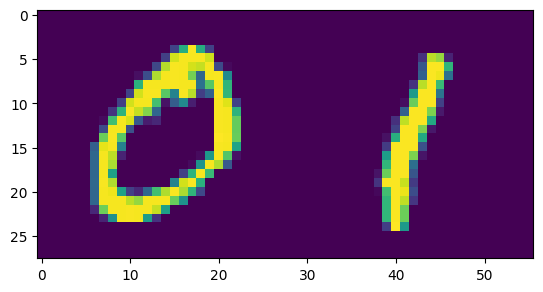

In [20]:
plt.imshow(np.concatenate((X_train[0], X_train[-1]), axis=1))

## PQC Approach. 13 qubits circuit

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train.reshape(-1, 28*28))
X_train_scaled = scaler.transform(X_train.reshape(-1, 28*28))
X_test_scaled = scaler.transform(X_test.reshape(-1, 28*28))

n_pca = 6
pca = PCA(n_components=n_pca)
pca.fit(X_train_scaled)

X_train_transform = pca.transform(X_train_scaled)
X_test_transform = pca.transform(X_test_scaled)

print(X_train_transform.shape, Y_train.shape)
print(X_test_transform.shape, Y_test.shape)

(400, 6) (400,)
(200, 6) (200,)


In [26]:
X_train_transform[0]

array([ 7.91882982, -4.61375223,  0.59233633, -1.44470015, -2.82157947,
       -1.66127436])

### Model AngleEmbeding and Strongly Entangling layers

For this first approach, we are only considering a PCA of the MNIST data, taking just 6 features as the real data, for this we build the PQC model using [Angle Embeding](https://docs.pennylane.ai/en/stable/code/api/pennylane.AngleEmbedding.html) to encode the real data in the circuit and we implement trainable parameters using a [Strongly Entangling Layer](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html)

In [131]:
#dev = qml.device("default.qubit", wires = 6)
#@qml.qnode(dev)
#def data_enconding(feature_vector, qubits):
#    qml.AngleEmbedding(features=feature_vector, wires= qubits, rotation='Y')
#    return qml.state()

def PQC(image, params, qbits):
    qml.AngleEmbedding(features=image, wires= qbits, rotation='Y')
    qml.StronglyEntanglingLayers(weights=params, wires= qbits)




Training_circ is the circuit which takes two image and embeds both as quantum states using PQC function. Then, we apply a SWAP test to compare those quantum states and with the measurement to calculate the fidelity between those quantum states.

In [173]:
dev13 = qml.device("default.qubit", wires = 13)
@qml.qnode(dev13)
def training_circ(image1, image2, params1, qbits):
    PQC(image1, params1, [qbits[0], qbits[1], qbits[2], qbits[3], qbits[4], qbits[5]])
    PQC(image2, params1, [qbits[7], qbits[8], qbits[9], qbits[10], qbits[11], qbits[12]])

    # swap test
    qml.Hadamard(wires=6)

    for i in range(6):
      qml.CSWAP(wires = [6, i, i+7])

    qml.Hadamard(wires=6)

    return qml.expval(qml.PauliZ(6))


/usr/local/lib/python3.10/dist-packages/pennylane/drawer/mpldrawer.py:634: UserWarning: Some control indicators are hidden behind an operator. Consider re-ordering your circuit wires to ensure all control indicators are visible.
  warnings.warn(


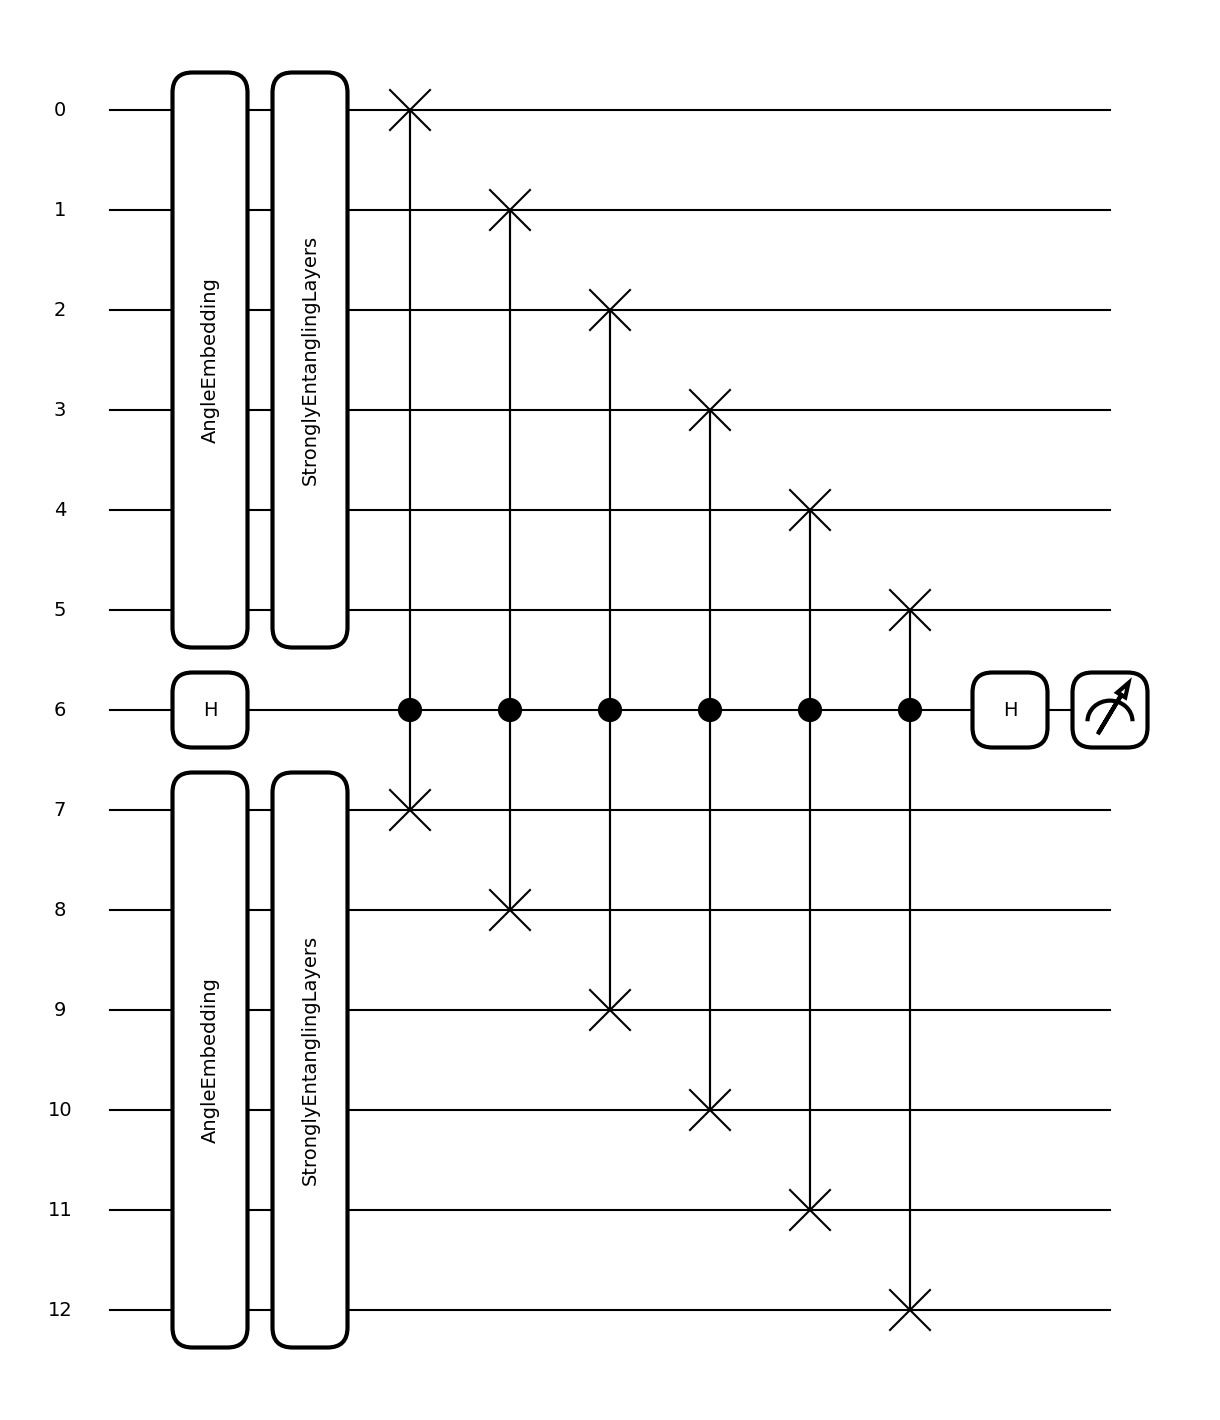

In [174]:
fig, ax = qml.draw_mpl(training_circ)(X_train_transform[0], X_train_transform[1], np.zeros(shape=(2,6,3)),  list(range(13)))
fig.show()

#### Generator and real data comparing using swap test

The GAN is build from the real data in qubits $1-4$, the generator circuit in qubits $5-8$ and a SWAP test between the two states to measure the similarity.
The result of the SWAP test is read out from qubit $0$.

In [137]:
def data_enconding(data, qubits):
  qml.AngleEmbedding(data, wires = qubits)
  #return qml.state()

def generator(params, qubits):
  qml.StronglyEntanglingLayers(params, wires = qubits)

dev13 = qml.device('default.qubit', wires=13)

@qml.qnode(dev13)
def training_circ(data, paramsg, qbits):
    # top 5 qbits real data
    data_enconding(data, [qbits[0],qbits[1],qbits[2],qbits[3], qbits[4], qbits[5]])

    # bottom 5 qubits generator ansatz
    generator(paramsg, [qbits[7],qbits[8],qbits[9], qbits[10], qbits[11], qbits[12]])
    #generator_ry(paramsg, [qbits[6],qbits[7],qbits[8],qbits[9], qbits[10]])

    # swap test
    qml.Hadamard(wires=6)

    for i in range(6):
      qml.CSWAP(wires = [6, i, i+7])

    qml.Hadamard(wires=6)

    return qml.expval(qml.PauliZ(6))

In [138]:
dev15 = qml.device('default.qubit', wires=15)

@qml.qnode(dev15)
def training_circ_5(data, paramsg, qbits):
    # top 5 qbits real data
    data_enconding(data, [qbits[0],qbits[1],qbits[2],qbits[3], qbits[4]])

    # bottom 5 qubits generator ansatz
    generator(paramsg, [qbits[10],qbits[11],qbits[12],qbits[13], qbits[14]])
    #generator_ry(paramsg, [qbits[6],qbits[7],qbits[8],qbits[9], qbits[10]])

    # swap test
    qml.Hadamard(wires=5)
    qml.Hadamard(wires=6)
    qml.Hadamard(wires=7)
    qml.Hadamard(wires=8)
    qml.Hadamard(wires=9)

    qml.CSWAP(wires=[5,0,10])
    qml.CSWAP(wires=[6,1,11])
    qml.CSWAP(wires=[7,2,12])
    qml.CSWAP(wires=[8,3,13])
    qml.CSWAP(wires=[9,4,14])
    qml.Hadamard(wires=5)
    qml.Hadamard(wires=6)
    qml.Hadamard(wires=7)
    qml.Hadamard(wires=8)
    qml.Hadamard(wires=9)

    return [qml.expval(qml.PauliZ(i)) for i in range(5,10)]

Lets draw an example of the training circuit:

/usr/local/lib/python3.10/dist-packages/pennylane/drawer/mpldrawer.py:634: UserWarning: Some control indicators are hidden behind an operator. Consider re-ordering your circuit wires to ensure all control indicators are visible.
  warnings.warn(


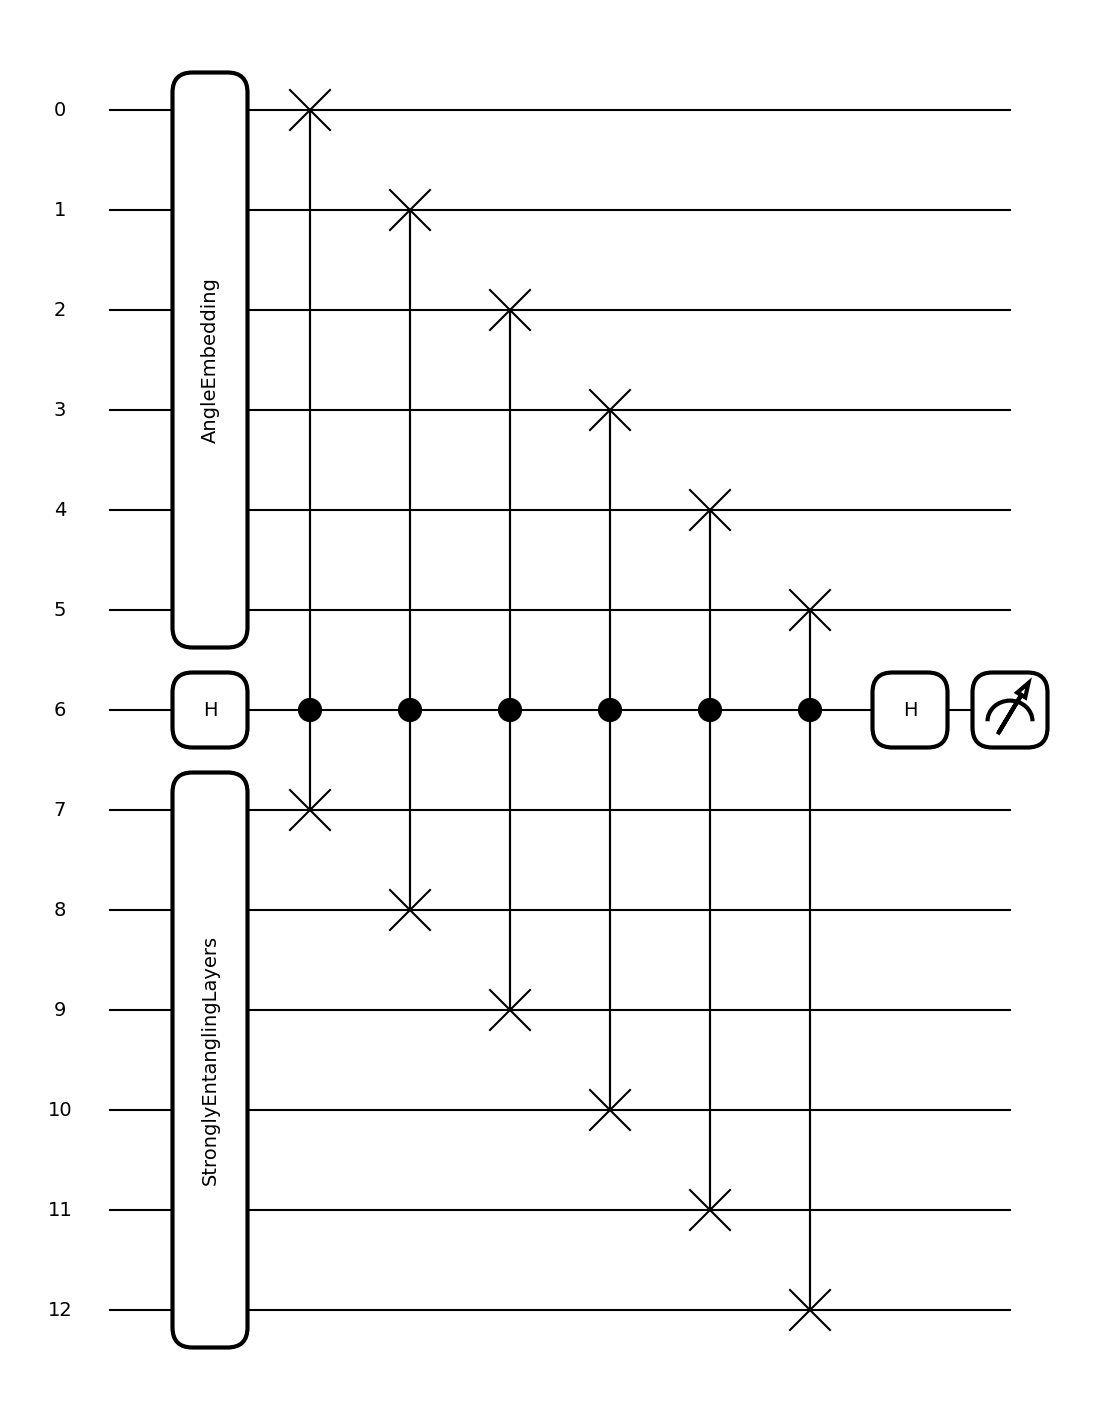

In [139]:
fig, ax = qml.draw_mpl(training_circ)(X_train_transform[0], np.zeros(shape=(2,6,3)), list(range(14)) )
fig.show()

### Training

Training parameters:
1. Epochs
2. Batch size
3. Learning rate
4. Layers in the Strongly Entangling generator circuit

In [182]:
epochs = 5
batch_size=16
learning_rate=0.01
layers = 15
qubits = list(range(13))

To train the circuit we first define the loss function.

It is given by
$$\mathcal{L}=-\log\big[\big|\big<\sigma|G(\Theta_g)\big>\big|^2\big]$$
where the fidelity is exatly the output of the swap test.

We also add a small regularization $\epsilon$ in the $\log$

In [183]:
def cost_batch(params1, batch, reg=0.000001):
    loss = 0.0
    for i in batch:
        f = training_circ(i, i+1, params1, qubits) + reg
        loss += - np.log(f)
    return loss / len(batch)

In [184]:
def cost_batch_5(paramsg, batch, reg=0.000001):
    loss = 0.0
    for i in batch:
      f=0
      for j in range(5):
        f += training_circ_5(i, paramsg, qubits)[j] + reg
      loss += - np.log(f)
    return loss / len(batch)

We initialize the parameters of the generator and the optimizer

In [185]:
# trainable params
from pennylane import numpy as np
paramsg_train = np.random.uniform(0,np.pi, size=(layers,6,3), requires_grad=True)
#paramsg_train2 = np.random.uniform(0,np.pi, size=(layers,6,3), requires_grad=True)

In [186]:
optg = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

To train we iterate over the data in batches

In [187]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In the training loop we save the loss.

Note that we define a the loss function with a lambda function for every batch of data to have only a single argument when passing it to the optimizer.

In [188]:
losshist = []

start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(X_train_transform[:100], batch_size=batch_size)):
        cost_fn = lambda p: cost_batch(p, Xbatch)
        paramsg_train = optg.step(cost_fn, paramsg_train)
        print(j, end="\r")

    loss = cost_batch(paramsg_train, X_train_transform[:100])
    losshist += [loss]

    print(f"Epoch: {it} | Loss: {loss:.3} | ")
    print("____")

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Epoch: 0 | Loss: 1.57 | 
____
Epoch: 1 | Loss: 1.57 | 
____
Epoch: 2 | Loss: 1.57 | 
____
Epoch: 3 | Loss: 1.57 | 
____
Epoch: 4 | Loss: 1.57 | 
____
Time for 5 epochs: 831.4791352748871


### Evaluation

Lets check the training results:

The loss evolution during training:

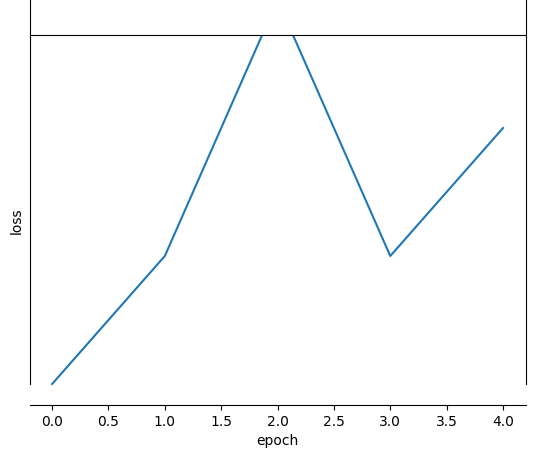

In [181]:
plt.plot(losshist)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')

## DataReuploading Approach. 3 qubits circuit

Attempt with DataReUploading technique and different unitary gates with trainable parameters. With this function we can embed an image with only one qubit.

In [200]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

In [201]:
# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T

Simple classifier with data reloading and fidelity loss

In [230]:
dev = qml.device("lightning.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=0))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

fig, ax = qml.draw_mpl(qcircuit)(np.random.random(3), np.array([0.92]), np.array(1))
fig.show()

Utility functions for testing and creating batches

In [203]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

Train a quantum classifier

In [190]:
Y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [214]:
import tensorflow
from tensorflow.keras.utils import to_categorical
Y_train_ohe = to_categorical(Y_train)
Y_test_ohe = to_categorical(Y_test)


label_0 = [1, 0]
label_1 = [0, 1]
state_labels = np.array([label_0, label_1], requires_grad=False)

In [215]:
# Generate training and test data

Xtrain = np.hstack((X_train_transform, np.zeros((X_train_transform.shape[0], 1), requires_grad=False)))

Xtest = np.hstack((X_test_transform, np.zeros((X_test_transform.shape[0], 1), requires_grad=False)))


label_0 = np.array([[0]])
label_1 = np.array([[1]])
state_labels = np.array([label_0, label_1], requires_grad=False)
# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, Xtrain, Y_train_ohe, state_labels)
accuracy_train = accuracy_score(Y_train_ohe, predicted_train)

predicted_test, fidel_test = test(params, Xtest, Y_test_ohe, state_labels)
accuracy_test = accuracy_score(Y_test_ohe, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, Xtest, Y_test_ohe, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(Xtrain, Y_train_ohe, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, Xtrain, Y_train_ohe, state_labels)
    accuracy_train = accuracy_score(Y_train_ohe, predicted_train)
    loss = cost(params, Xtrain, Y_train_ohe, state_labels)

    predicted_test, fidel_test = test(params, Xtest, Y_test, state_labels)
    accuracy_test = accuracy_score(Y_test_ohe, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

TypeError: Rot.__init__() got multiple values for argument 'wires'

Lets also check the distribution we get when sampling from the generator:

To do so we write a new qunode containing only the generator and sample from it.